In [10]:
import sys
from pathlib import Path

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))


from Pipeline.lib.calibration import StereoManager, CameraParameters, StereoParameters
from Pipeline.lib.pipeline import load_depth_model, compute_depth_map

calib_path = "/home/emilia/MasterOfFish/Pipeline/lib/stereo_calib/stereoMap.pickle"
sm = StereoManager()
sm.load_calibration(calib_path)



In [38]:
import cv2
import tensorflow as tf
import numpy as np

from hitnet import HitNet, ModelType, draw_disparity, draw_depth, CameraConfig, load_img

# Select model type
# model_type = ModelType.middlebury
# model_type = ModelType.flyingthings
model_type = ModelType.eth3d

if model_type == ModelType.middlebury:
	model_path = "models/middlebury_d400.pb"
elif model_type == ModelType.flyingthings:
	model_path = "models/flyingthings_finalpass_xl.pb"
elif model_type == ModelType.eth3d:
	model_path = "models/eth3d.pb"

baseline = np.linalg.norm(sm.stereo_parameters.t) 
focal_length = sm.cam_parameters[0].camera_matrix[0, 0]
hitnet_depth = HitNet(model_path, model_type, camera_config=CameraConfig(baseline=baseline, f=focal_length))



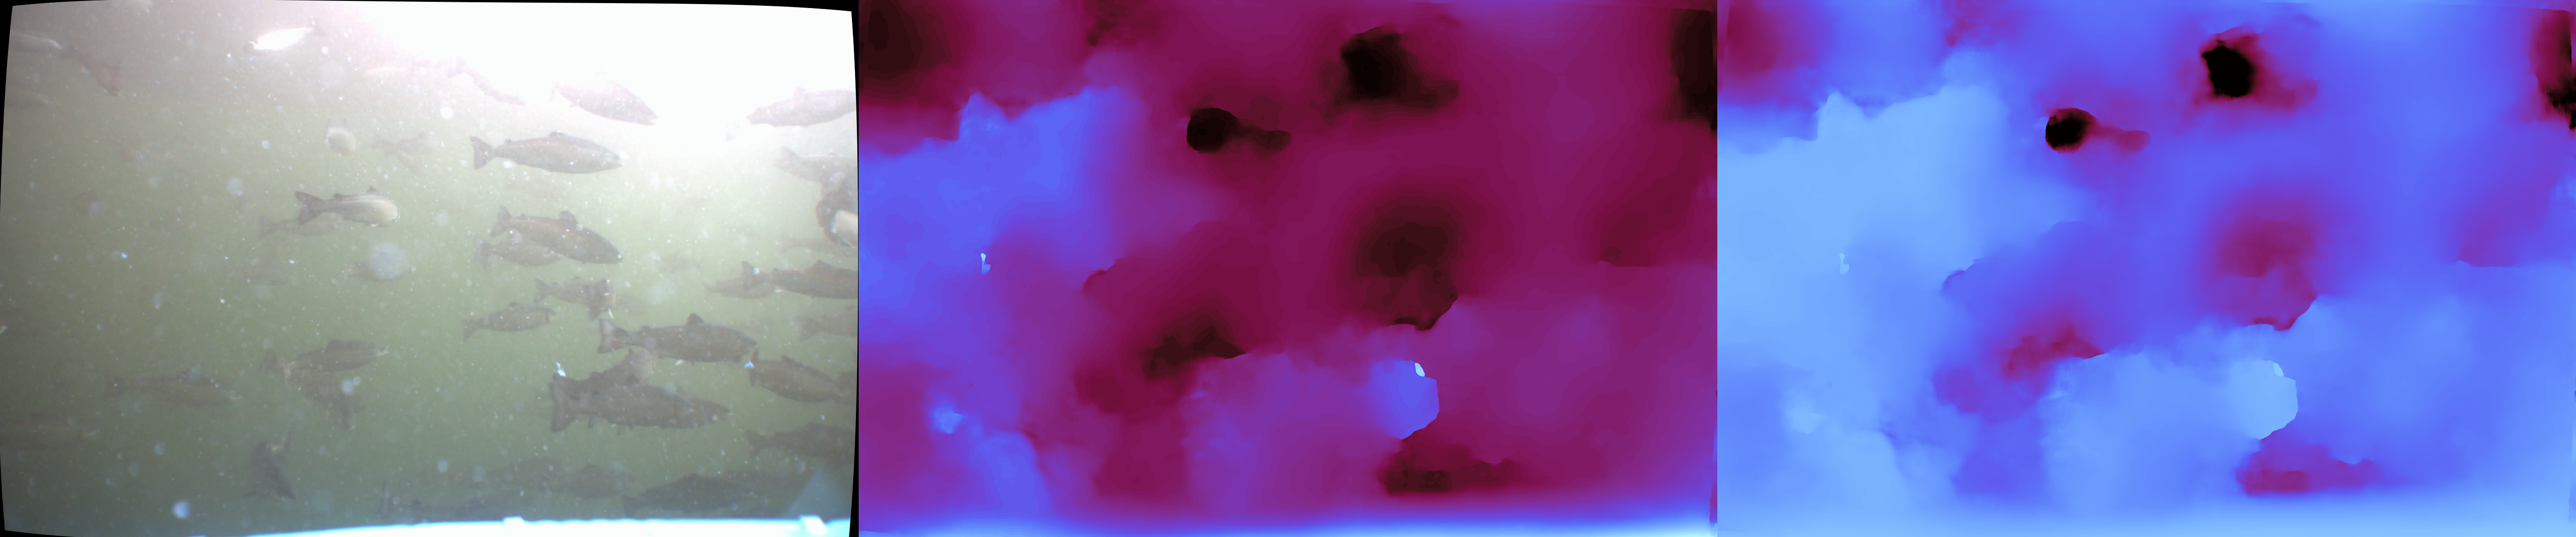

In [42]:
# Load images
import matplotlib.pyplot as plt
from PIL import Image
left_img = cv2.imread("/home/emilia/MasterOfFish/stereo_data/BY/frames/left/frame_1500.jpg")
right_img = cv2.imread("/home/emilia/MasterOfFish/stereo_data/BY/frames/right/frame_1500.jpg")


def rectify(l_img, r_img):
    # Applying stereo image rectification on the left image
    l_rect = cv2.remap(l_img,
                       sm.cam_parameters[0].map1,
                       sm.cam_parameters[0].map2,
                       interpolation=cv2.INTER_LINEAR,
                       borderMode=cv2.BORDER_CONSTANT)
    
    # Applying stereo image rectification on the right image
    r_rect = cv2.remap(r_img,
                       sm.cam_parameters[1].map1,
                       sm.cam_parameters[1].map2,
                       interpolation=cv2.INTER_LINEAR,
                       borderMode=cv2.BORDER_CONSTANT)

    return l_rect, r_rect

left_img, right_img = rectify(left_img, right_img)


# Estimate the depth
disparity_map = hitnet_depth(left_img, right_img)
depth_map = hitnet_depth.get_depth()

color_disparity = draw_disparity(disparity_map)
color_depth = draw_depth(depth_map, max_dist=10000)
combined_image = np.hstack((left_img, color_disparity, color_depth))

img = Image.fromarray(combined_image, 'RGB')
display(img)

